In [ ]:
import tensorflow as tf
import torch

# Check if TensorFlow sees the GPU
print("TensorFlow GPU:", tf.config.list_physical_devices('GPU'))

# Check GPU details with PyTorch
if torch.cuda.is_available():
    print("PyTorch GPU Name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected")


TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch GPU Name: NVIDIA A100-SXM4-40GB


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import re
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
import pandas as pd

# Define a function to process each subtitle file
def process_subtitle_file(file_path, file_number):
    start_times = []
    end_times = []
    texts = []
    file_numbers = []  # List to store the file number for each subtitle

    current_text = ""
    current_start = None
    current_end = None

    # Read the file content
    with open(file_path, 'r') as file:
        subtitle_lines = file.readlines()

    # Skip the first three lines
    subtitle_lines = subtitle_lines[3:]

    # Process each line
    for line in subtitle_lines:
        # Match timestamp lines
        match = re.match(r'(\d{2}:\d{2}:\d{2})\.\d{3} --> (\d{2}:\d{2}:\d{2})\.\d{3}', line)
        if match:
            # Save ongoing text block
            if current_start and current_text.strip():
                cleaned_text = re.sub(r"<.*?>", "", current_text.strip())
                texts.append(cleaned_text)
                start_times.append(current_start)
                end_times.append(current_end)
                file_numbers.append(file_number)  # Add the file number

            # Start a new block
            current_start = match.group(1)
            current_end = match.group(2)
            current_text = ""
        elif line.strip():
            # Accumulate text lines
            current_text += line.strip() + " "

    # Save the last block
    if current_start and current_text.strip():
        cleaned_text = re.sub(r"<.*?>", "", current_text.strip())
        texts.append(cleaned_text)
        start_times.append(current_start)
        end_times.append(current_end)
        file_numbers.append(file_number)  # Add the file number

    # Post-process rows to handle lines with only bracketed text
    for i in range(1, len(texts)):
        # Check if the current row contains only bracketed text
        if re.fullmatch(r"[\[\(\{].*?[\]\)\}]", texts[i].strip()):
            # Append this text to the previous row
            texts[i - 1] = f"{texts[i - 1]} {texts[i]}".strip()
            texts[i] = ""  # Clear the current row

    # Remove empty rows
    texts = [text for text in texts if text.strip()]
    start_times = [start_times[i] for i in range(len(texts))]
    end_times = [end_times[i] for i in range(len(texts))]
    file_numbers = [file_numbers[i] for i in range(len(texts))]

    # Merge rows with fewer than 5 words into the previous row (within the same file)
    i = 1
    while i < len(texts):
        if len(texts[i].split()) < 5:  # Check word count
            # Merge with the previous row
            texts[i - 1] = f"{texts[i - 1]} {texts[i]}".strip()
            texts.pop(i)  # Remove the current row
            end_times[i - 1] = end_times[i]  # Update the end time of the merged row
            start_times.pop(i)
            end_times.pop(i)
            file_numbers.pop(i)  # Remove the file number of the merged row
        else:
            i += 1

    return start_times, end_times, texts, file_numbers

# Initialize data containers
all_start_times = []
all_end_times = []
all_texts = []
all_file_numbers = []  # List to hold the file numbers for each subtitle line

# Folder containing subtitle files
folder_path = "/content/drive/MyDrive/jyoti_text_train_data/"

# Process all subtitle files in the folder
file_number = 1  # Initialize the file number tracker
for filename in os.listdir(folder_path):
    if filename.endswith(".vtt"):  # Ensure only subtitle files are processed
        file_path = os.path.join(folder_path, filename)
        st, et, tx, fn = process_subtitle_file(file_path, file_number)

        all_start_times.extend(st)
        all_end_times.extend(et)
        all_texts.extend(tx)
        all_file_numbers.extend(fn)

        file_number += 1  # Increment file number after processing each file

# Populate the funny column after preprocessing
funny_flags = []
bracket_pattern = r"[\[\(\{].*?[\]\)\}]"

for text in all_texts:
    if re.search(bracket_pattern, text):
        funny_flags.append(1)  # Mark as funny if it contains bracketed text
    else:
        funny_flags.append(0)  # Otherwise, mark as not funny

# Create the final DataFrame
subtitle_df = pd.DataFrame({
    "start_time": all_start_times,
    "end_time": all_end_times,
    "text": all_texts,
    "funny": funny_flags,
    "file_number": all_file_numbers  # Add the file number column
})

# Save the DataFrame to a CSV file (optional)
subtitle_df.to_csv("subtitles_processed.csv", index=False)



In [ ]:
# Apply the function to remove bracketed text
def remove_bracketed_text(text):
    # Use regex to remove text within [], (), and {}
    cleaned_text = re.sub(r"\[.*?\]|\(.*?\)|\{.*?\}", "", text)
    return cleaned_text.strip()

# Apply the function to the text column
subtitle_df["text"] = subtitle_df["text"].apply(remove_bracketed_text)

# Drop rows where the 'text' column is empty
subtitle_df = subtitle_df[subtitle_df['text'] != ""]

# Reset the index after dropping rows
subtitle_df.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame
subtitle_df.head()
subtitle_df.shape

(18706, 5)

In [ ]:
subtitle_df.head()

,start_time,end_time,text,funny,file_number
0,00:00:00,00:00:02,"Thank you. Sit, sit. Thank you.",0,1
1,00:00:02,00:00:03,Thank you. I appreciate it.,0,1
2,00:00:03,00:00:05,It's great to be back in my home of New York C...,1,1
3,00:00:05,00:00:09,I've been on the road a little bit. I was in A...,0,1
4,00:00:09,00:00:12,Whatever. It wasn't that great.,1,1


## CNN word_tokenizer

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import pandas as pd

# Text cleaning function
def clean_text(text):
    # Remove any words inside brackets (both [], {}, and ())
    text = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}', '', text)
    # Remove any other non-alphabetic characters (if needed)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Prepare data
# Assuming subtitle_df is the dataframe with 'text' and 'funny' columns
subtitle_df['cleaned_text'] = subtitle_df['text'].apply(clean_text)

# Tokenizer setup
max_tokens = 50  # Maximum number of tokens in a sentence
vocab_size = 100000  # Vocabulary size for tokenization
tokenizer = Tokenizer(num_words=vocab_size)

# Fit the tokenizer on the cleaned text data
tokenizer.fit_on_texts(subtitle_df['cleaned_text'])

# Convert text to sequences of word tokens (integer encoded)
sequences = tokenizer.texts_to_sequences(subtitle_df['cleaned_text'])

# Pad sequences to ensure consistent input length (e.g., 50 words per sentence)
X_pad = pad_sequences(sequences, maxlen=max_tokens, padding='post')

# Prepare target labels
y = subtitle_df['funny'].values

# Split data into train and test
# Assuming the 'file_index' column exists to identify files
num_train_files = 30
train_data = subtitle_df[subtitle_df['file_number'] <= num_train_files]
test_data = subtitle_df[subtitle_df['file_number'] > num_train_files]

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['cleaned_text']), maxlen=max_tokens, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['cleaned_text']), maxlen=max_tokens, padding='post')
y_train = train_data['funny'].values
y_test = test_data['funny'].values

# Define CNN model for word tokens
embedding_dim = 128  # Embedding dimension
num_filters = 64  # Number of convolution filters
window_size = 3  # Sliding window size

word_input = tf.keras.layers.Input(shape=(max_tokens,))

# Embedding layer for word tokens
word_embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_tokens)(word_input)

# Convolutional layer for word tokens
conv_word = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=window_size, activation='relu')(word_embedding)

# Max-pooling layer for word tokens
max_pool_word = tf.keras.layers.GlobalMaxPooling1D()(conv_word)

# Fully connected layers
dense_layer = tf.keras.layers.Dense(64, activation='relu')(max_pool_word)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)  # Binary classification

# Create the word token CNN model
word_cnn_model = tf.keras.Model(inputs=word_input, outputs=output_layer, name="WordTokenCNN")

# Compile the model
word_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
word_cnn_model.summary()

# Train the model
batch_size = 32
epochs = 3
history = word_cnn_model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=1)

# Evaluate the model
test_loss, test_accuracy = word_cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "WordTokenCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 128)             │      12,800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 48, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,828,865 (48.94 MB)

 Trainable params: 12,828,865 (48.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
212/212 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7958 - loss: 0.5143 - val_accuracy: 0.8484 - val_loss: 0.4236
Epoch 2/3
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8399 - loss: 0.3798 - val_accuracy: 0.7170 - val_loss: 0.5629
Epoch 3/3
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9153 - loss: 0.2235 - val_accuracy: 0.8028 - val_loss: 0.5570
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8211 - loss: 0.5419
Test Loss: 0.4711, Test Accuracy: 0.8438


In [ ]:

# Predict probabilities for the test set
y_pred_proba_wt = word_cnn_model.predict(X_test)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## Baseline acuracy

In [ ]:
# Calculate class distribution for training data
train_class_counts = train_data['funny'].value_counts()
train_baseline_class = train_class_counts.idxmax()  # The most frequent class in training data
train_baseline_accuracy = train_class_counts.max() / train_class_counts.sum()  # Proportion of majority class

print(f"Train Baseline Class: {train_baseline_class}")
print(f"Train Baseline Accuracy: {train_baseline_accuracy:.4f}")


Train Baseline Class: 0
Train Baseline Accuracy: 0.8124


## Word2Vec model

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

# Text cleaning function
def clean_text(text):
    text = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()

# Prepare data
subtitle_df['cleaned_text'] = subtitle_df['text'].apply(clean_text)

# Load Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')
embedding_dim = word2vec_model.vector_size  # Dimensionality of Word2Vec embeddings

# Tokenizer setup
max_tokens = 50  # Maximum number of tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(subtitle_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(subtitle_df['cleaned_text'])
X_pad = pad_sequences(sequences, maxlen=max_tokens, padding='post')

# Create embedding matrix
def create_embedding_matrix(vocab, word2vec_model, embedding_dim):
    embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))  # +1 for padding token
    for word, idx in vocab.items():
        if word in word2vec_model:
            embedding_matrix[idx] = word2vec_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))
    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer.word_index, word2vec_model, embedding_dim)

# Prepare target labels
y = subtitle_df['funny'].values

# Split data into train and test
num_train_files = 30
train_data = subtitle_df[subtitle_df['file_number'] <= num_train_files]
test_data = subtitle_df[subtitle_df['file_number'] > num_train_files]

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['cleaned_text']), maxlen=max_tokens, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['cleaned_text']), maxlen=max_tokens, padding='post')
y_train = train_data['funny'].values
y_test = test_data['funny'].values

# Define CNN model with Word2Vec embeddings
word_input = tf.keras.layers.Input(shape=(max_tokens,))
word2vec_embedding = tf.keras.layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_tokens,
    trainable=False  # Freeze embeddings
)(word_input)

conv_word = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(word2vec_embedding)
max_pool_word = tf.keras.layers.GlobalMaxPooling1D()(conv_word)
dense_layer = tf.keras.layers.Dense(64, activation='relu')(max_pool_word)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)

word2vec_cnn_model = tf.keras.Model(inputs=word_input, outputs=output_layer, name="Word2VecCNN")

# Compile the model
word2vec_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
word2vec_cnn_model.summary()

# Train the model
batch_size = 32
epochs = 4
history = word2vec_cnn_model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=1)

# Evaluate the model
test_loss, test_accuracy = word2vec_cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Word2VecCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 50, 300)             │       2,191,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 48, 64)              │          57,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,253,389 (8.60 MB)

 Trainable params: 61,889 (241.75 KB)

 Non-trainable params: 2,191,500 (8.36 MB)

Epoch 1/4
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8048 - loss: 0.5092 - val_accuracy: 0.8390 - val_loss: 0.4603
Epoch 2/4
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8134 - loss: 0.4522 - val_accuracy: 0.8455 - val_loss: 0.4434
Epoch 3/4
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8309 - loss: 0.4201 - val_accuracy: 0.8301 - val_loss: 0.4595
Epoch 4/4
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8408 - loss: 0.4020 - val_accuracy: 0.8372 - val_loss: 0.4558
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 0.4293
Test Loss: 0.3845, Test Accuracy: 0.8689


In [ ]:
# Step 12: Predict probabilities for the test set
y_pred_prob_wv = word2vec_cnn_model.predict(X_test)



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import re
import gensim.downloader as api

# Text cleaning function
def clean_text(text):
    text = re.sub(r'\[.*?\]|\(.*?\)|\{.*?\}', '', text)  # Remove words in brackets
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters
    return text.lower()

# Prepare data
subtitle_df['cleaned_text'] = subtitle_df['text'].apply(clean_text)

# Load Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')
embedding_dim = word2vec_model.vector_size  # Dimensionality of Word2Vec embeddings

# Tokenizer setup
seq_length = 10  # Sequence length for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(subtitle_df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(subtitle_df['cleaned_text'])

# Create embedding matrix
def create_embedding_matrix(vocab, word2vec_model, embedding_dim):
    embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
    for word, idx in vocab.items():
        if word in word2vec_model:
            embedding_matrix[idx] = word2vec_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))
    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer.word_index, word2vec_model, embedding_dim)

# Pad sequences
X_pad = pad_sequences(sequences, maxlen=seq_length, padding='post')

# Prepare target labels
y = subtitle_df['funny'].values

# Split data into train and test
num_train_files = 30
train_data = subtitle_df[subtitle_df['file_number'] <= num_train_files]
test_data = subtitle_df[subtitle_df['file_number'] > num_train_files]

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['cleaned_text']), maxlen=seq_length, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['cleaned_text']), maxlen=seq_length, padding='post')
y_train = train_data['funny'].values
y_test = test_data['funny'].values

# Define LSTM model
word_input = tf.keras.layers.Input(shape=(seq_length,))
word2vec_embedding = tf.keras.layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=seq_length,
    trainable=False  # Freeze embeddings
)(word_input)

lstm_layer = tf.keras.layers.LSTM(64, return_sequences=False)(word2vec_embedding)  # LSTM with 64 units
dense_layer = tf.keras.layers.Dense(64, activation='relu')(lstm_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)

lstm_model = tf.keras.Model(inputs=word_input, outputs=output_layer, name="LSTMModel")

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train the model
batch_size = 32
epochs = 6
history = lstm_model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=1)

# Evaluate the model
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LSTMModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 10, 300)             │       2,191,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          93,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,289,165 (8.73 MB)

 Trainable params: 97,665 (381.50 KB)

 Non-trainable params: 2,191,500 (8.36 MB)

Epoch 1/6
212/212 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8029 - loss: 0.5054 - val_accuracy: 0.8413 - val_loss: 0.4182
Epoch 2/6
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8199 - loss: 0.4348 - val_accuracy: 0.8532 - val_loss: 0.3989
Epoch 3/6
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8334 - loss: 0.4228 - val_accuracy: 0.8502 - val_loss: 0.4101
Epoch 4/6
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8495 - loss: 0.3813 - val_accuracy: 0.8579 - val_loss: 0.3988
Epoch 5/6
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8585 - loss: 0.3635 - val_accuracy: 0.8555 - val_loss: 0.4198
Epoch 6/6
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8726 - loss: 0.3292 - val_accuracy: 0.8520 - val_loss: 0.4288
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8453 - loss: 0.4340
Test Loss: 0.3943, Test Accuracy: 0.8675


In [ ]:
# Step 12: Predict probabilities for the test set
y_pred_prob_lstm = lstm_model.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


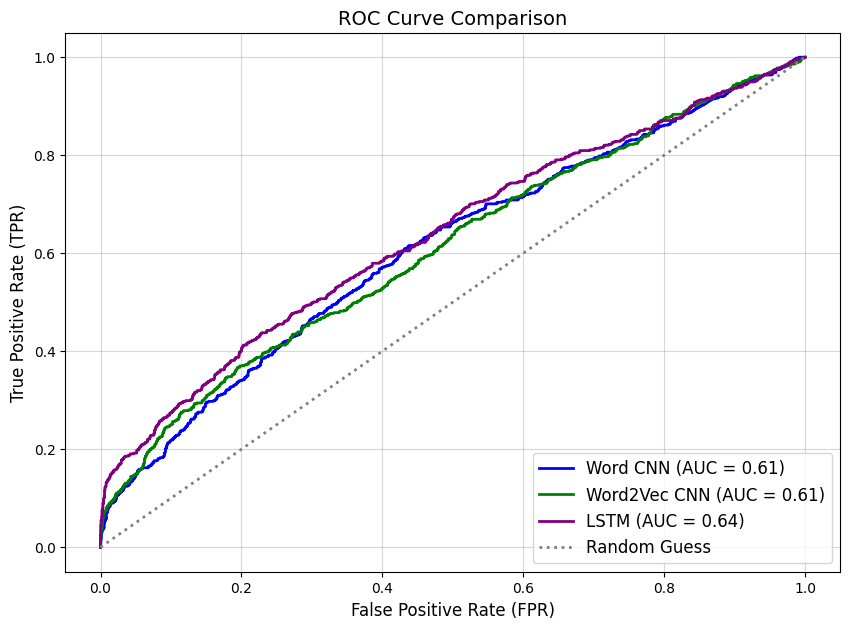

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for Word CNN Model
fpr_wt, tpr_wt, _ = roc_curve(y_test, y_pred_proba_wt)
roc_auc_wt = auc(fpr_wt, tpr_wt)

# Compute ROC curve and AUC for Word2Vec CNN Model
fpr_wv, tpr_wv, _ = roc_curve(y_test, y_pred_prob_wv)
roc_auc_wv = auc(fpr_wv, tpr_wv)

# Compute ROC curve and AUC for LSTM Model
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot all ROC curves
plt.figure(figsize=(10, 7))

# Plot solid lines for models
plt.plot(fpr_wt, tpr_wt, color='blue', lw=2, label=f'Word CNN (AUC = {roc_auc_wt:.2f})')
plt.plot(fpr_wv, tpr_wv, color='green', lw=2, label=f'Word2Vec CNN (AUC = {roc_auc_wv:.2f})')
plt.plot(fpr_lstm, tpr_lstm, color='purple', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')

# Plot dotted gray line for random guess
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=2, label='Random Guess')

# Graph labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.5)
plt.show()


## Transformers

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer
model_name = "mohameddhiab/humor-no-humor"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Display the model architecture
print(model)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Get and display the tokenizer type
tokenizer_type = type(tokenizer)
print(tokenizer_type)

<class 'transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast'>


In [ ]:
# Assuming your original DataFrame is 'df'

# Filter rows where file_number <= 30 for training
train_df = subtitle_df[subtitle_df['file_number'] <= 30]

# Filter rows where file_number > 30 for testing
test_df = subtitle_df[subtitle_df['file_number'] > 30]

# Checking the split data
print("Train Data:")
print(train_df.head())
print("\nTest Data:")
print(test_df.head())


Train Data:
  start_time  end_time                                               text  \
0   00:00:00  00:00:02                    Thank you. Sit, sit. Thank you.   
1   00:00:02  00:00:03                        Thank you. I appreciate it.   
2   00:00:03  00:00:05  It's great to be back in my home of New York C...   
3   00:00:05  00:00:09  I've been on the road a little bit. I was in A...   
4   00:00:09  00:00:12                    Whatever. It wasn't that great.   

   funny  file_number  
0      0            1  
1      0            1  
2      1            1  
3      0            1  
4      1            1  

Test Data:
      start_time  end_time                                               text  \
10077   00:00:00  00:00:29  Announcer: FROM NEW YORK CITY, "COMEDY CENTRAL...   
10078   00:00:29  00:00:34  OH MY GOD, THE LOVE. THAT IS SO COOL. UM, MAN,...   
10079   00:00:34  00:00:35                      FIRST OF ALL, I GOT TO GIVE A   
10080   00:00:35  00:00:36                   

In [ ]:
from torch.utils.data import Dataset
import torch
from transformers import DistilBertTokenizer

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]

        # Tokenize the text and return attention masks, input_ids, and labels
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,  # Add [CLS] and [SEP] tokens
            max_length=self.max_len,
            padding='max_length',  # Pad sequences to the same length
            truncation=True,  # Truncate texts longer than max_len
            return_attention_mask=True,  # Generate attention masks
            return_tensors='pt'  # Return PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),  # Flatten to 1D tensor
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)  # Target label as tensor
        }

# Define the tokenizer (DistilBERT tokenizer here)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Create the train and test datasets
train_dataset = CustomDataset(
    texts=train_df['text'].tolist(),
    labels=train_df['funny'].tolist(),
    tokenizer=tokenizer,
    max_len=128  # Adjust max length as needed
)

test_dataset = CustomDataset(
    texts=test_df['text'].tolist(),
    labels=test_df['funny'].tolist(),
    tokenizer=tokenizer,
    max_len=128  # Adjust max length as needed
)

# Create DataLoader for batching
from torch.utils.data import DataLoader

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Check one example from the training data
for batch in train_loader:
    print(batch)
    break


{'input_ids': tensor([[  101,  2008,  1005,  ...,     0,     0,     0],
        [  101,  5382,  2027,  ...,     0,     0,     0],
        [  101,  1998,  1045,  ...,     0,     0,     0],
        ...,
        [  101,  2748,  1010,  ...,     0,     0,     0],
        [  101,  2057,  2175,  ...,     0,     0,     0],
        [  101, 25430, 13355,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])}


In [ ]:
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

# Load the pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Prepare the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  # Number of training steps (adjust for epochs)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

# Loop through epochs
for epoch in range(3):  # Adjust number of epochs as needed
    epoch_loss = 0.0

    # Loop through batches in the training data
    for batch in train_loader:
        # Zero out gradients
        optimizer.zero_grad()

        # Move data to the device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass: get model output
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Calculate loss
        loss = outputs.loss

        # Backward pass: compute gradients
        loss.backward()

        # Optimize the model
        optimizer.step()

        # Track epoch loss
        epoch_loss += loss.item()

    # Print loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")

    # Optional: Update the learning rate scheduler
    scheduler.step()

# Save the fine-tuned model after training
model.save_pretrained("./fine_tuned_model")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.37637407965366804
Epoch 2, Loss: 0.3100676748132895
Epoch 3, Loss: 0.21969934545959982


In [ ]:
# Set the model to evaluation mode
model.eval()

# Variables to track metrics
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    # Iterating over the test_loader (which contains test data)
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Get predictions
        _, predicted = torch.max(outputs.logits, dim=1)

        # Update correct and total counts
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on test data: {accuracy * 100:.2f}%")



Accuracy on test data: 78.20%


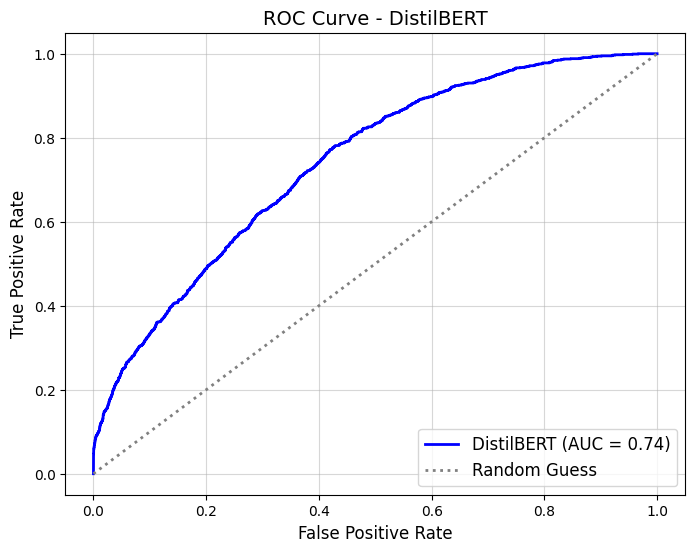

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

# Variables to track true labels and probabilities
y_test = []
y_pred_proba = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get probabilities for the positive class
        probabilities = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()

        # Append to tracking lists
        y_test.extend(labels.cpu().numpy())
        y_pred_proba.extend(probabilities)

# Convert lists to numpy arrays
y_test = np.array(y_test)
y_pred_proba = np.array(y_pred_proba)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'DistilBERT (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - DistilBERT', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.5)
plt.show()


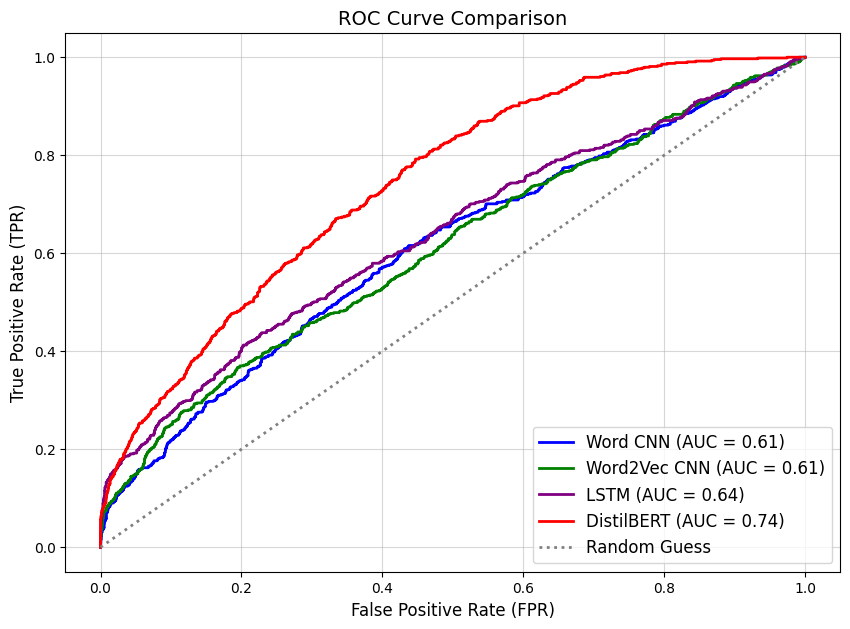

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for Word CNN Model
fpr_wt, tpr_wt, _ = roc_curve(y_test, y_pred_proba_wt)
roc_auc_wt = auc(fpr_wt, tpr_wt)

# Compute ROC curve and AUC for Word2Vec CNN Model
fpr_wv, tpr_wv, _ = roc_curve(y_test, y_pred_prob_wv)
roc_auc_wv = auc(fpr_wv, tpr_wv)

# Compute ROC curve and AUC for LSTM Model
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute ROC curve and AUC for DistilBERT Model
fpr_distilbert, tpr_distilbert, _ = roc_curve(y_test, y_pred_proba)
roc_auc_distilbert = auc(fpr_distilbert, tpr_distilbert)

# Plot all ROC curves
plt.figure(figsize=(10, 7))

# Plot solid lines for models
plt.plot(fpr_wt, tpr_wt, color='blue', lw=2, label=f'Word CNN (AUC = {roc_auc_wt:.2f})')
plt.plot(fpr_wv, tpr_wv, color='green', lw=2, label=f'Word2Vec CNN (AUC = {roc_auc_wv:.2f})')
plt.plot(fpr_lstm, tpr_lstm, color='purple', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_distilbert, tpr_distilbert, color='red', lw=2, label=f'DistilBERT (AUC = {roc_auc_distilbert:.2f})')

# Plot dotted gray line for random guess
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=2, label='Random Guess')

# Graph labels and title
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.5)
plt.show()


# Testing on New data

In [ ]:



# Initialize data containers
all_start_times = []
all_end_times = []
all_texts = []
all_file_numbers = []  # List to hold the file numbers for each subtitle line
all_file_names = []  # List to hold the corresponding file names

# Folder containing subtitle files
folder_path = "/content/drive/MyDrive/test_files_subtitles_29_nov"

# Process all subtitle files in the folder
file_number = 1  # Initialize the file number tracker
for filename in os.listdir(folder_path):
    if filename.endswith(".vtt"):  # Ensure only subtitle files are processed
        file_path = os.path.join(folder_path, filename)
        st, et, tx, fn = process_subtitle_file(file_path, file_number)

        all_start_times.extend(st)
        all_end_times.extend(et)
        all_texts.extend(tx)
        all_file_numbers.extend(fn)
        all_file_names.extend([filename]*len(tx))  # Add the file name for each subtitle line

        file_number += 1  # Increment file number after processing each file

# Populate the funny column after preprocessing
funny_flags = []
bracket_pattern = r"[\[\(\{].*?[\]\)\}]"

for text in all_texts:
    if re.search(bracket_pattern, text):
        funny_flags.append(1)  # Mark as funny if it contains bracketed text
    else:
        funny_flags.append(0)  # Otherwise, mark as not funny

# Create the final DataFrame
subtitle_df = pd.DataFrame({
    "start_time": all_start_times,
    "end_time": all_end_times,
    "text": all_texts,
    "funny": funny_flags,
    "file_number": all_file_numbers,  # Add the file number column
    "file_name":all_file_names
})

# Save the DataFrame to a CSV file (optional)
subtitle_df.to_csv("subtitles_processed_Test.csv", index=False)



In [ ]:

# Filter rows where file_number > 30 for testing
test_df = subtitle_df

print("\nTest Data:")
print(test_df.head())



Test Data:
  start_time  end_time                                               text  \
0   00:00:01  00:00:04  -Our first guest tonight is a world-renowned j...   
1   00:00:04  00:00:06  Tonight he's going to perform some comedy for us.   
2   00:00:06  00:00:10  He also hosts "The Ron Burgundy Podcast" on iH...   
3   00:00:10  00:00:38  Please welcome to the show Ron Burgundy, every...   
4   00:00:38  00:00:40  Always, always great to be back here in New Yo...   

   funny  file_number  
0      0            1  
1      0            1  
2      0            1  
3      1            1  
4      0            1  


In [ ]:
test_df.shape

(1564, 5)

In [ ]:
test_df['file_number'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

Accuracy on test data: 83.70%


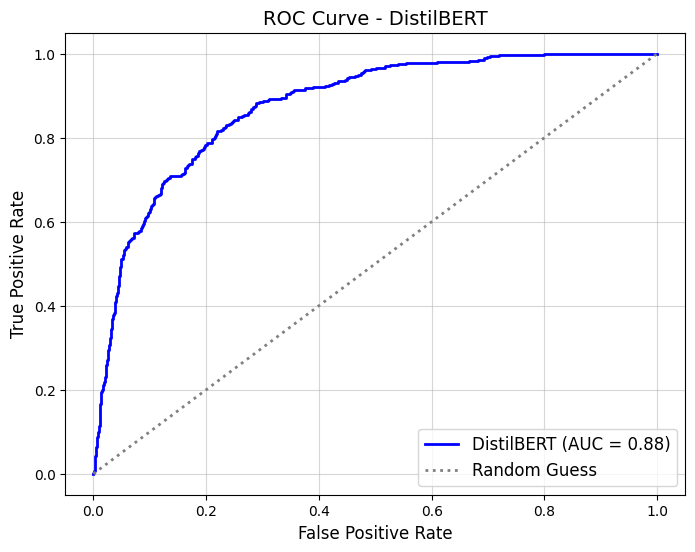

In [ ]:
test_dataset = CustomDataset(
    texts=test_df['text'].tolist(),
    labels=test_df['funny'].tolist(),
    tokenizer=tokenizer,
    max_len=128  # Adjust max length as needed
)

# Create DataLoader for batching
from torch.utils.data import DataLoader


test_loader = DataLoader(test_dataset, batch_size=16)


# Set the model to evaluation mode
model.eval()

# Variables to track metrics
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    # Iterating over the test_loader (which contains test data)
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Get predictions
        _, predicted = torch.max(outputs.logits, dim=1)

        # Update correct and total counts
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
model.eval()

# Variables to track true labels and probabilities
y_test = []
y_pred_proba = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Get probabilities for the positive class
        probabilities = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()

        # Append to tracking lists
        y_test.extend(labels.cpu().numpy())
        y_pred_proba.extend(probabilities)

# Convert lists to numpy arrays
y_test = np.array(y_test)
y_pred_proba = np.array(y_pred_proba)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'DistilBERT (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - DistilBERT', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.5)
plt.show()



Combining Audio and Text Model

In [ ]:
import pandas as pd
df_audio = pd.read_csv('test_amplitude_based_features_df_29_Nov.csv')
df_text = pd.read_csv('/content/subtitles_processed_Test.csv')



In [ ]:
df_text.head()

,start_time,end_time,text,funny,file_number,file_name
0,00:00:01,00:00:04,-Our first guest tonight is a world-renowned j...,0,1,Ron Burgundy Performs Stand-Up with a Hipster ...
1,00:00:04,00:00:06,Tonight he's going to perform some comedy for us.,0,1,Ron Burgundy Performs Stand-Up with a Hipster ...
2,00:00:06,00:00:10,"He also hosts ""The Ron Burgundy Podcast"" on iH...",0,1,Ron Burgundy Performs Stand-Up with a Hipster ...
3,00:00:10,00:00:38,"Please welcome to the show Ron Burgundy, every...",1,1,Ron Burgundy Performs Stand-Up with a Hipster ...
4,00:00:38,00:00:40,"Always, always great to be back here in New Yo...",0,1,Ron Burgundy Performs Stand-Up with a Hipster ...


In [ ]:
df_text.shape

(1564, 6)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = df_audio

# Define the look-back window size
lookback = 5

# Initialize a list to store processed data
processed_data = []

# Group by audio file to process each file independently
for audio_file, group in df.groupby("audio_file_name"):
    group = group.sort_values("start_time").reset_index(drop=True)

    # Skip files with insufficient windows
    if len(group) <= lookback:
        continue

    # Create look-back features
    for i in range(lookback, len(group)):
        row = group.iloc[i].copy()

        # Append look-back features
        for j in range(1, lookback + 1):
            lookback_row = group.iloc[i - j]
            for col in ['peak_to_avg_ratio', 'avg_to_dev_ratio', 'dynamic_range',
           'zero_crossing_rate', 'amplitude_skewness', 'total_pause_duration',
           'energy_ratio', 'energy_decay', 'std_amp', 'kurt_energy',
            'start_time', 'end_time']:
                row[f"{col}_t-{j}"] = lookback_row[col]

        processed_data.append(row)

# Combine processed data into a new DataFrame
processed_df = pd.DataFrame(processed_data)
processed_df.head()

,Unnamed: 0,peak_to_avg_ratio,avg_to_dev_ratio,dynamic_range,zero_crossing_rate,amplitude_skewness,total_pause_duration,energy_ratio,energy_decay,std_amp,...,dynamic_range_t-5,zero_crossing_rate_t-5,amplitude_skewness_t-5,total_pause_duration_t-5,energy_ratio_t-5,energy_decay_t-5,std_amp_t-5,kurt_energy_t-5,start_time_t-5,end_time_t-5
5,304,15.203507,0.994059,0.226410,0.151750,2.484938,0.824375,153931.893586,-54.928886,0.020237,...,0.196758,0.158156,1.964285,0.846313,1.333262e+24,19.018540,0.024507,28.922819,0,10
6,305,18.100727,1.186333,0.321375,0.164500,2.051400,0.406125,201176.930725,37.751730,0.022464,...,0.224806,0.186188,2.526307,0.585500,7.152415e+04,19.339735,0.017115,77.357666,10,20
7,306,13.633932,1.188843,0.237060,0.149144,2.096000,0.375812,209111.477205,-51.670868,0.022633,...,0.290379,0.177712,2.548498,0.753250,1.335501e+05,5.572632,0.020123,89.669883,20,30
8,307,14.219511,0.840259,0.184919,0.174888,2.504284,0.573688,112227.837949,-8.448013,0.017647,...,0.249640,0.158256,2.572602,0.593000,1.497793e+05,22.552788,0.020489,89.725550,30,40
9,308,15.540255,0.926597,0.220602,0.140169,2.232301,0.993938,133073.694890,12.802128,0.018756,...,0.200439,0.166656,2.460160,0.815937,1.461812e+05,36.525528,0.020206,59.230700,40,50


In [ ]:
processed_df = processed_df.drop(['Unnamed: 0'],axis=1)

In [ ]:
X_test_audio = processed_df.drop(columns=['audio_file_name', 'start_time', 'end_time', 'next_target'])
y_test_audio = processed_df['next_target']


In [ ]:

X_test_text = df_text['text']
y_test_text = df_text['funny']

In [ ]:
import joblib

# Load the XGBoost model
model_path = "Random_Forest_model.pkl"
rf_model = joblib.load(model_path)

# Use X_test_audio as the test dataset
# Ensure X_test_audio is preprocessed in the same way as the training data
proba_audio = rf_model.predict_proba(X_test_audio)

# Print the probabilistic estimates
print("Probabilistic Estimates:")
print(proba_audio)

Probabilistic Estimates:
[[0.43  0.57 ]
 [0.42  0.58 ]
 [0.4   0.6  ]
 [0.395 0.605]
 [0.4   0.6  ]
 [0.37  0.63 ]
 [0.415 0.585]
 [0.395 0.605]
 [0.37  0.63 ]
 [0.42  0.58 ]
 [0.41  0.59 ]
 [0.37  0.63 ]
 [0.42  0.58 ]
 [0.42  0.58 ]
 [0.38  0.62 ]
 [0.42  0.58 ]
 [0.365 0.635]
 [0.42  0.58 ]
 [0.395 0.605]
 [0.365 0.635]
 [0.42  0.58 ]
 [0.375 0.625]
 [0.405 0.595]
 [0.42  0.58 ]
 [0.405 0.595]
 [0.365 0.635]
 [0.42  0.58 ]
 [0.395 0.605]
 [0.41  0.59 ]
 [0.43  0.57 ]
 [0.365 0.635]
 [0.42  0.58 ]
 [0.44  0.56 ]
 [0.37  0.63 ]
 [0.395 0.605]
 [0.44  0.56 ]
 [0.39  0.61 ]
 [0.43  0.57 ]
 [0.385 0.615]
 [0.41  0.59 ]
 [0.43  0.57 ]
 [0.43  0.57 ]
 [0.42  0.58 ]
 [0.415 0.585]
 [0.43  0.57 ]
 [0.405 0.595]
 [0.355 0.645]
 [0.42  0.58 ]
 [0.385 0.615]
 [0.395 0.605]
 [0.405 0.595]
 [0.415 0.585]
 [0.375 0.625]
 [0.45  0.55 ]
 [0.42  0.58 ]
 [0.395 0.605]
 [0.415 0.585]
 [0.44  0.56 ]
 [0.405 0.595]
 [0.415 0.585]
 [0.42  0.58 ]
 [0.47  0.53 ]
 [0.385 0.615]
 [0.425 0.575]
 [0.43  0.57 ]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
processed_df.loc[:,'pred_laugh'] = proba_audio[:,1]

In [ ]:
y_pred_proba.shape

(1564,)

(array([795., 153., 111., 100.,  79.,  70.,  68.,  67.,  68.,  53.]),
 array([9.13497235e-04, 9.84612629e-02, 1.96009025e-01, 2.93556780e-01,
        3.91104549e-01, 4.88652319e-01, 5.86200058e-01, 6.83747828e-01,
        7.81295598e-01, 8.78843367e-01, 9.76391137e-01]),
 <BarContainer object of 10 artists>)

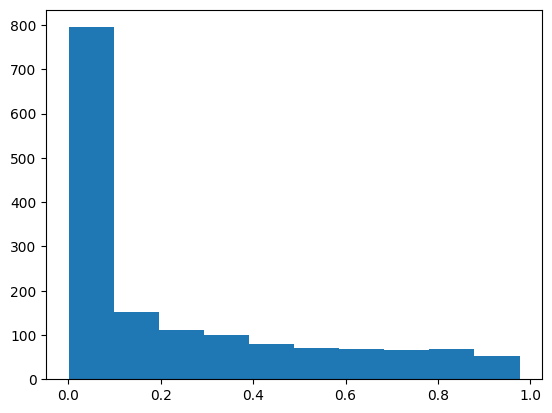

In [ ]:

plt.hist(y_pred_proba)

In [ ]:
# y_pred_proba.shape

df_text.loc[:,'pred_laugh_text'] = y_pred_proba[:]
df_text.head()
# prediction on text using distilbert

,start_time,end_time,text,funny,file_number,file_name,pred_laugh_text
0,00:00:01,00:00:04,-Our first guest tonight is a world-renowned j...,0,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.002423
1,00:00:04,00:00:06,Tonight he's going to perform some comedy for us.,0,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.004362
2,00:00:06,00:00:10,"He also hosts ""The Ron Burgundy Podcast"" on iH...",0,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.004909
3,00:00:10,00:00:38,"Please welcome to the show Ron Burgundy, every...",1,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.618793
4,00:00:38,00:00:40,"Always, always great to be back here in New Yo...",0,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.001769


In [ ]:
proba_audio.shape

(429, 2)

In [ ]:
processed_df.to_csv('processed_df_audio.csv')

In [ ]:
lookup = pd.read_csv('linking_table_TEST.csv')
lookup.head()

,subtitle_title,audio_title
0,‚ÄúA Gluten-Free Poodle‚Ä¶‚Äù - Derrick Stroup...,‚ÄúA Gluten-Free Poodle‚Ä¶‚Äù - Derrick Stroup...
1,Jim Gaffigan Tripped on Stage While Performing...,Jim Gaffigan Tripped on Stage While Performing...
2,Joe List Stand-Up.en.vtt,Joe List Stand-Up.mp3
3,Joyelle Nicole Johnson Stand-Up Performance.en...,Joyelle Nicole Johnson Stand-Up Performance.mp3
4,Love Is Like a Fart - Rosebud Baker - Stand-Up...,Love Is Like a Fart - Rosebud Baker - Stand-Up...


In [ ]:
merge1 = pd.merge(processed_df, lookup, how = 'left', left_on = 'audio_file_name', right_on = 'audio_title' )

In [ ]:
df_text.columns =  ['start_time','end_time','text','laughter','video_id','name','pred_laugh_text']

In [ ]:
df_text.head()

,start_time,end_time,text,laughter,video_id,name,pred_laugh_text
0,00:00:01,00:00:04,-Our first guest tonight is a world-renowned j...,0,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.002423
1,00:00:04,00:00:06,Tonight he's going to perform some comedy for us.,0,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.004362
2,00:00:06,00:00:10,"He also hosts ""The Ron Burgundy Podcast"" on iH...",0,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.004909
3,00:00:10,00:00:38,"Please welcome to the show Ron Burgundy, every...",1,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.618793
4,00:00:38,00:00:40,"Always, always great to be back here in New Yo...",0,1,Ron Burgundy Performs Stand-Up with a Hipster ...,0.001769


In [ ]:


# Check the updated structure
df_text.columns

Index(['start_time', 'end_time', 'text', 'laughter', 'video_id', 'name',
       'pred_laugh_text'],
      dtype='object')

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import re

# Updated reset_and_align_time function
def reset_and_align_time(df, df_text):
    """
    Reset and align start_time and end_time for two dataframes (df and df_text).
    Both start at 1900-01-01 00:00:00.000 and reset for each video.
    """
    base_time = datetime(1900, 1, 1)  # Start time

    # Process df (interval-based time in seconds)
    def process_df(group):
        group['aligned_start_time'] = group['start_time'].apply(
            lambda x: base_time + timedelta(seconds=x - 10)
        )
        group['aligned_end_time'] = group['end_time'].apply(
            lambda x: base_time + timedelta(seconds=x - 10)
        )
        return group

    # Process df_text (time in "HH:MM:SS" format)
    def process_df_text(group):
        """
        Align start and end times for df_text in "HH:MM:SS" format.
        """
        group['aligned_start_time'] = group['start_time'].apply(
            lambda x: base_time + timedelta(
                hours=pd.to_datetime(x, format="%H:%M:%S").hour,
                minutes=pd.to_datetime(x, format="%H:%M:%S").minute,
                seconds=pd.to_datetime(x, format="%H:%M:%S").second
            )
        )
        group['aligned_end_time'] = group['end_time'].apply(
            lambda x: base_time + timedelta(
                hours=pd.to_datetime(x, format="%H:%M:%S").hour,
                minutes=pd.to_datetime(x, format="%H:%M:%S").minute,
                seconds=pd.to_datetime(x, format="%H:%M:%S").second
            )
        )
        return group

    # Group by audio_file_name or video_id and process each group
    df = df.groupby('audio_file_name', group_keys=False).apply(process_df)
    df_text = df_text.groupby('video_id', group_keys=False).apply(process_df_text)

    return df, df_text

# # Example DataFrames
# merge1 = pd.DataFrame({
#     'audio_file_name': ['video1', 'video2'],
#     'start_time': [10, 20],
#     'end_time': [15, 30]
# })

# df_text = pd.DataFrame({
#     'video_id': ['video1', 'video2'],
#     'start_time': ['00:00:01', '00:00:05'],
#     'end_time': ['00:00:04', '00:00:10']
# })

# Apply the updated function
aligned_merge1, aligned_df_text = reset_and_align_time(merge1, df_text)

# Outputs
print(aligned_merge1[['audio_file_name', 'start_time', 'aligned_start_time', 'aligned_end_time']])
print(aligned_df_text[['video_id', 'start_time', 'aligned_start_time', 'aligned_end_time']])

<ipython-input-121-e23152dbe626>:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('audio_file_name', group_keys=False).apply(process_df)


                                       audio_file_name  start_time  \
0    Jim Gaffigan Tripped on Stage While Performing...          50   
1    Jim Gaffigan Tripped on Stage While Performing...          60   
2    Jim Gaffigan Tripped on Stage While Performing...          70   
3    Jim Gaffigan Tripped on Stage While Performing...          80   
4    Jim Gaffigan Tripped on Stage While Performing...          90   
..                                                 ...         ...   
424  ＂Lil Wayne’s a Safe Little Gremlin” - Eagle Wi...         340   
425  ＂Lil Wayne’s a Safe Little Gremlin” - Eagle Wi...         350   
426  ＂Lil Wayne’s a Safe Little Gremlin” - Eagle Wi...         360   
427  ＂Lil Wayne’s a Safe Little Gremlin” - Eagle Wi...         370   
428  ＂Lil Wayne’s a Safe Little Gremlin” - Eagle Wi...         380   

     aligned_start_time    aligned_end_time  
0   1900-01-01 00:00:40 1900-01-01 00:00:50  
1   1900-01-01 00:00:50 1900-01-01 00:01:00  
2   1900-01-01 00:01:

<ipython-input-121-e23152dbe626>:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_text = df_text.groupby('video_id', group_keys=False).apply(process_df_text)


In [ ]:
aligned_merge1.columns

Index(['peak_to_avg_ratio', 'avg_to_dev_ratio', 'dynamic_range',
       'zero_crossing_rate', 'amplitude_skewness', 'total_pause_duration',
       'energy_ratio', 'energy_decay', 'std_amp', 'kurt_energy',
       'audio_file_name', 'start_time', 'end_time', 'next_target',
       'peak_to_avg_ratio_t-1', 'avg_to_dev_ratio_t-1', 'dynamic_range_t-1',
       'zero_crossing_rate_t-1', 'amplitude_skewness_t-1',
       'total_pause_duration_t-1', 'energy_ratio_t-1', 'energy_decay_t-1',
       'std_amp_t-1', 'kurt_energy_t-1', 'start_time_t-1', 'end_time_t-1',
       'peak_to_avg_ratio_t-2', 'avg_to_dev_ratio_t-2', 'dynamic_range_t-2',
       'zero_crossing_rate_t-2', 'amplitude_skewness_t-2',
       'total_pause_duration_t-2', 'energy_ratio_t-2', 'energy_decay_t-2',
       'std_amp_t-2', 'kurt_energy_t-2', 'start_time_t-2', 'end_time_t-2',
       'peak_to_avg_ratio_t-3', 'avg_to_dev_ratio_t-3', 'dynamic_range_t-3',
       'zero_crossing_rate_t-3', 'amplitude_skewness_t-3',
       'total_pause_

In [ ]:
aligned_df_text.columns

Index(['start_time', 'end_time', 'text', 'laughter', 'video_id', 'name',
       'pred_laugh_text', 'aligned_start_time', 'aligned_end_time'],
      dtype='object')

In [ ]:
# Function to check overlap
def check_overlap(row, audio_df):
    """
    Filter audio rows matching the current text row's name and overlapping times.
    """
    matched_audio = audio_df[
        (audio_df['subtitle_title'] == row['name']) &  # Match subtitle title
        (audio_df['aligned_start_time'] < row['aligned_end_time']) &  # Overlap condition
        (audio_df['aligned_end_time'] > row['aligned_start_time'])  # Overlap condition
    ]
    return matched_audio

# Collect matches and compute predictions
results = []
intermediate_matches = []  # To store matches for inspection

for _, text_row in aligned_df_text.iterrows():
    matched_audio = check_overlap(text_row, merge1)

    if not matched_audio.empty:
        # Collect intermediate matches with additional details
        for _, match_row in matched_audio.iterrows():
            intermediate_matches.append({
                'text_start_time': text_row['start_time'],
                'text_end_time': text_row['end_time'],
                'text_name': text_row['name'],
                'text_pred': text_row['pred_laugh_text'],
                'audio_file_name': match_row['audio_file_name'],
                'audio_start_time': match_row['aligned_start_time'],
                'audio_end_time': match_row['aligned_end_time'],
                'audio_pred': match_row['pred_laugh']
            })

        # Average predictions of matching audio intervals
        avg_audio_pred = matched_audio['pred_laugh'].mean()
        # Combine with text prediction (assuming text prediction exists)
        text_pred = text_row.get('pred_laugh_text', 0.5)  # Example text prediction
        final_pred = (avg_audio_pred + text_pred) / 2

        results.append({
            'name': text_row['name'],
            'start_time': text_row['start_time'],
            'end_time': text_row['end_time'],
            'avg_audio_pred': avg_audio_pred,
            'text_pred': text_pred,
            'final_pred': final_pred,
            'target': text_row['laughter']
        })

# Create a DataFrame for the intermediate matches
matches_df = pd.DataFrame(intermediate_matches)

# Save the matches DataFrame for inspection
matches_df.to_csv("intermediate_matches_with_details.csv", index=False)

# Create a final DataFrame for the aggregated results
final_df = pd.DataFrame(results)

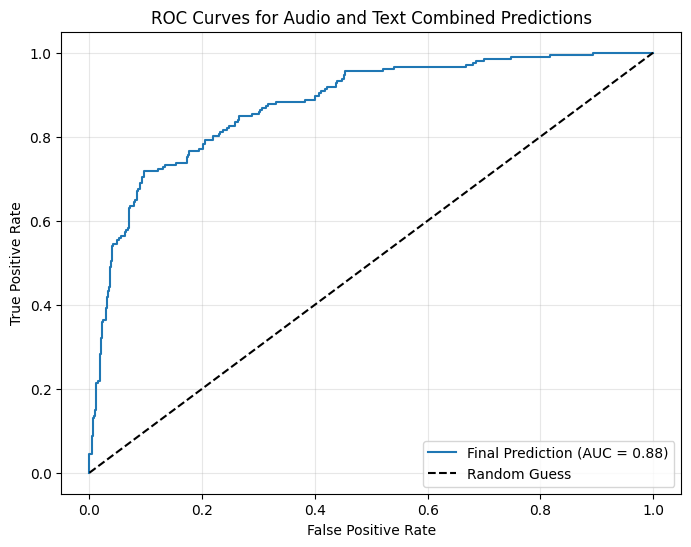

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Example DataFrame (replace with actual `final_df`)
# final_df should have columns: avg_audio_pred, text_pred, final_pred, target
# target is the true label (0 or 1)

# Compute ROC curves and AUC for individual predictions and final prediction
def plot_roc_curves(final_df):
    plt.figure(figsize=(8, 6))

    # Audio Prediction
    fpr_audio, tpr_audio, _ = roc_curve(final_df['target'], final_df['avg_audio_pred'])
    auc_audio = roc_auc_score(final_df['target'], final_df['avg_audio_pred'])
    #plt.plot(fpr_audio, tpr_audio, label=f"Audio Prediction (AUC = {auc_audio:.2f})")

    # Text Prediction
    fpr_text, tpr_text, _ = roc_curve(final_df['target'], final_df['text_pred'])
    auc_text = roc_auc_score(final_df['target'], final_df['text_pred'])
    #plt.plot(fpr_text, tpr_text, label=f"Text Prediction (AUC = {auc_text:.2f})")

    # Final Prediction
    fpr_final, tpr_final, _ = roc_curve(final_df['target'], final_df['final_pred'])
    auc_final = roc_auc_score(final_df['target'], final_df['final_pred'])
    plt.plot(fpr_final, tpr_final, label=f"Final Prediction (AUC = {auc_final:.2f})")

    # Plot formatting
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Audio and Text Combined Predictions")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Replace this with your actual DataFrame containing predictions and target
plot_roc_curves(final_df)

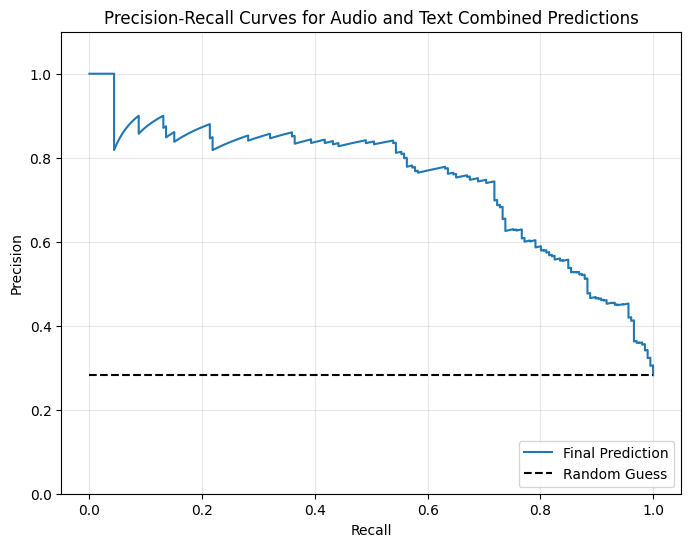

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute PR curve and Average Precision (AP) for individual predictions and final prediction
def plot_pr_curves(final_df):
    plt.figure(figsize=(8, 6))

    # Final Prediction
    precision_final, recall_final, _ = precision_recall_curve(final_df['target'], final_df['final_pred'])
    ap_final = average_precision_score(final_df['target'], final_df['final_pred'])
    plt.plot(recall_final, precision_final, label=f"Final Prediction")

    # Baseline (random classifier)
    random_baseline = final_df['target'].mean()
    plt.plot([0, 1], [random_baseline, random_baseline], 'k--', label="Random Guess")

    # Plot formatting
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves for Audio and Text Combined Predictions")
    plt.legend(loc="lower right")
    plt.ylim((0,1.1))
    plt.grid(alpha=0.3)
    plt.show()

# Replace this with your actual DataFrame containing predictions and target
plot_pr_curves(final_df)

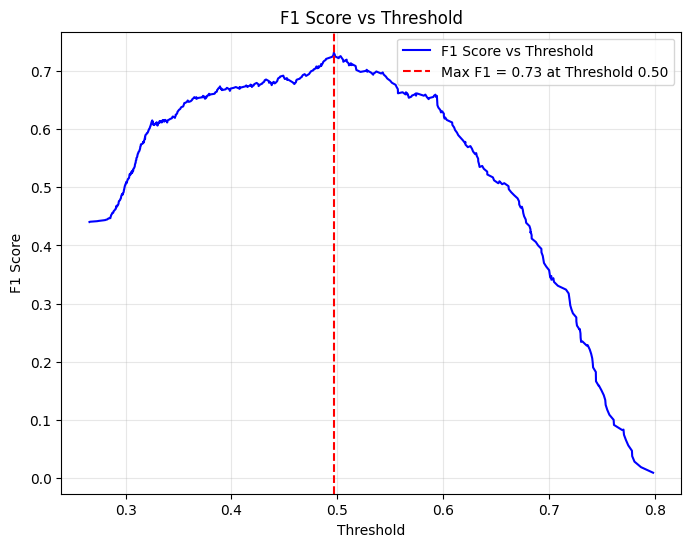

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score



# Compute F1 scores for all thresholds
precision, recall, thresholds = precision_recall_curve(final_df['target'], final_df['final_pred'])

# Calculate F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find the threshold with maximum F1 score
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
max_f1 = f1_scores[max_f1_index]

# Plot max F1 against all thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1 Score vs Threshold", color='blue')
plt.axvline(x=max_f1_threshold, color='red', linestyle='--', label=f"Max F1 = {max_f1:.2f} at Threshold {max_f1_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
final_df.to_csv('combined_pred_of_distill_and_audio_rf.csv')